In [ ]:
import os
import pickle
import random
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
from torch import optim

plt.switch_backend('agg')
import numpy as np
from tqdm import tqdm

from models import EncoderGRU, AttnDecoderGRU, EncoderLSTM, DecoderLSTM
from utils import Lang, tensorsFromPair, timeSince, showPlot

%matplotlib inline

E:\Anaconda\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = 'SCAN-master'
# dataset_path = '/Users/liuzhaoqi/Liuzhaoqi/UCPH/ATNLP/ATNLP_5/dataset'
task_name = 'length'  # or 'length'

train_file_name = '{}_split/tasks_{}_{}.txt'.format(task_name, 'train', task_name)
test_file_name = '{}_split/tasks_{}_{}.txt'.format(task_name, 'test', task_name)
train_file_path = os.path.join(dataset_path, train_file_name)
test_file_path = os.path.join(dataset_path, test_file_name)
# train_file_path, test_file_path

SOS_token = 0
EOS_token = 1

command_le = Lang('command')
action_le = Lang('action')


def dataloader(path):
    with open(path, 'r') as f:
        dataset = f.readlines()

    def preprocess_data(line):
        line = line.strip().split()
        split_index = line.index('OUT:')
        inp = line[1: split_index]
        outp = line[split_index + 1:]
        command_le.addSentence(inp)
        action_le.addSentence(outp)
        return [inp, outp]

    pairs = list(map(preprocess_data, dataset))
    input_commands, output_actions = np.transpose(pairs).tolist()
    return input_commands, output_actions, pairs


commands_train, actions_train, pairs_train = dataloader(train_file_path)
commands_test, actions_test, pairs_test = dataloader(test_file_path)

MAX_LENGTH = max([len(action) for action in actions_test]) + 1

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          model='gru'):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_hiddens = torch.zeros(input_length, encoder.hidden_size, device=device)

    loss = 0
    gold_pred = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        
        if model == 'gru':
            encoder_hiddens[ei] += encoder_hidden[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    preds = []
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            if model == 'gru':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_hiddens)
            elif model == 'lstm':
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            preds.append(topi.squeeze().item())
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    

    else:
        for di in range(target_length):
            if model == 'gru':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_hiddens)
            elif model == 'lstm':
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            preds.append(topi.squeeze().item())
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                target_length = di + 1
                break
                
    correct = torch.equal(torch.Tensor(preds).to(device), target_tensor.squeeze())

    loss.backward()

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=5.0)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length, correct


def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100,
               learning_rate=0.001, model='gru'):
    start = time.time()

    accuracy = 0 
    plot_losses = []
    plot_accs = []
    print_loss_total = 0
    plot_loss_total = 0
    print_pred_total = 0
    print_label_total = 0
    plot_pred_total = 0
    plot_label_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs_train), command_le, action_le)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # target_length = target_tensor.size(0)

        loss, correct = train(input_tensor, target_tensor, encoder, decoder, 
                              encoder_optimizer, decoder_optimizer, criterion, 
                              model)
        print_pred_total += int(correct)
        plot_pred_total += int(correct)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:            
            print_acc_avg = print_pred_total / print_every
            accuracy = print_acc_avg
            print_loss_avg = print_loss_total / print_every
            print_pred_total = 0
            print_label_total = 0
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f acc: %.4f' % (timeSince(start, iter / n_iters),
                                                         iter, iter / n_iters * 100, print_loss_avg, print_acc_avg))

        if iter % plot_every == 0:
            plot_acc_avg = plot_pred_total / plot_every
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_accs.append(plot_acc_avg)
            plot_loss_total = 0
            plot_pred_total = 0
            plot_label_total = 0

    showPlot(plot_losses, plot_accs)
    return accuracy


def evaluate(encoder, decoder, pair, model='gru', max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor, target_tensor = tensorsFromPair(pair, command_le, action_le)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_hiddens = torch.zeros(input_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            
            if model == 'gru':
                encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            if model == 'gru':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_hiddens)
                decoder_attentions[di] = decoder_attention.squeeze().data
            elif model == 'lstm':
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(action_le.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di+1]


def evaluate_model(encoder, decoder, test_pairs, model='gru'):
    command_cnt = Counter([len(test_pair[0]) for test_pair in test_pairs])
    action_cnt = Counter([len(test_pair[1]) for test_pair in test_pairs])
    command_correct_cnt = defaultdict(int)
    action_correct_cnt = defaultdict(int)
    correct = 0

    for pair in tqdm(test_pairs):
        preds, attentions = evaluate(encoder, decoder, pair, model=model)
        preds = preds[:-1]
        target_output = pair[1]
        if preds == target_output:
            command_correct_cnt[len(pair[0])] += 1
            action_correct_cnt[len(pair[1])] += 1
            correct += 1
            
    command_correct_cnt = dict(command_correct_cnt)
    action_correct_cnt = dict(action_correct_cnt)
    command_cnt = dict(command_cnt)
    action_cnt = dict(action_cnt)

    command_acc = {}
    for command_length, cnt in command_cnt.items():
        command_acc[command_length] = command_correct_cnt.get(
            command_length, 0) / cnt

    action_acc = {}
    for action_length, cnt in action_cnt.items():
        action_acc[action_length] = action_correct_cnt.get(
            action_length, 0) / cnt
            
    return command_acc, action_acc, correct / len(test_pairs)


def evaluate_fixed_length(encoder, decoder, pair, model='gru', max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor, target_tensor = tensorsFromPair(pair, command_le, action_le)
        input_length = input_tensor.size()[0]
        output_length = target_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_hiddens = torch.zeros(input_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

            if model == 'gru':
                encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(output_length, input_length)

        for di in range(output_length):
            if model == 'gru':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_hiddens)
                decoder_attentions[di] = decoder_attention.squeeze().data
            elif model == 'lstm':
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(2)
            if topi[0][0].item() == EOS_token and di != output_length - 1:
                topi = topi[0][1]
            else:
                topi = topi[0][0]
            
            decoded_words.append(action_le.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions
    
    
def evaluate_model_fix(encoder, decoder, test_pairs, model='gru'):
    command_cnt = Counter([len(test_pair[0]) for test_pair in test_pairs])
    action_cnt = Counter([len(test_pair[1]) for test_pair in test_pairs])
    command_correct_cnt = defaultdict(int)
    action_correct_cnt = defaultdict(int)
    correct = 0

    for pair in tqdm(test_pairs):
        preds, attentions = evaluate_fixed_length(encoder, decoder, pair, model=model)
        preds = preds[:-1]
        target_output = pair[1]
        if preds == target_output:
            command_correct_cnt[len(pair[0])] += 1
            action_correct_cnt[len(pair[1])] += 1
            correct += 1
            
    command_correct_cnt = dict(command_correct_cnt)
    action_correct_cnt = dict(action_correct_cnt)
    command_cnt = dict(command_cnt)
    action_cnt = dict(action_cnt)

    command_acc = {}
    for command_length, cnt in command_cnt.items():
        command_acc[command_length] = command_correct_cnt.get(
            command_length, 0) / cnt

    action_acc = {}
    for action_length, cnt in action_cnt.items():
        action_acc[action_length] = action_correct_cnt.get(
            action_length, 0) / cnt
            
    return command_acc, action_acc, correct / len(test_pairs)


def evaluateRandomly(encoder, decoder, model='gru', n=10):
    for i in range(n):
        pair = random.choice(pairs_test)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair, model=model)
        output_sentence = output_words
        print('<', output_sentence)
        print('')
        

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    attentions = attentions.cpu().numpy().transpose()
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + ['<SOS>'] + input_sentence, fontsize=15)
    ax.set_xticklabels([''] + output_words, rotation=90, fontsize=15)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(encoder, decoder, pair, model='gru'):
    output_words, attentions = evaluate(
        encoder, decoder, pair, model=model)
    print('input =', pair[0])
    print('output =', output_words)
    showAttention(pair[0], output_words, attentions)
    


def evaluateAndShowAttentionExample(encoder, decoder, model='gru'):
    for i in range(5, len(pairs_test)):
        preds, attentions = evaluate(encoder, decoder, pairs_test[i], model=model)
        preds = preds[:-1]
        target_output = pairs_test[i][1]
        if preds == target_output:
            evaluateAndShowAttention(encoder, decoder, pairs_test[i])
            break
        
        
def main_run(hidden_size, num_iter, num_runs, model):

    input_size = command_le.n_words
    output_size = action_le.n_words

    best_encoder = None
    best_decoder = None
    best_acc = 0

    command_accs, action_accs, overall_accs, train_accs = [], [], [], []

    for i in range(num_runs):
        if model == 'gru':
            encoder = EncoderGRU(input_size, hidden_size, num_layers=1, dropout=0.5).to(device)
            decoder = AttnDecoderGRU(hidden_size, output_size, dropout=0.5).to(device)

        elif model == 'lstm':
            encoder = EncoderLSTM(input_size, hidden_size, num_layers=2, dropout=0.5).to(device)
            decoder = DecoderLSTM(hidden_size, output_size, num_layers=2, dropout=0.5).to(device)

        accuracy_train = trainIters(encoder, decoder, num_iter, print_every=1000, model=model)
        acc_command, acc_action, acc_overall = evaluate_model(encoder, decoder, pairs_test, model=model)
            

        if acc_overall > best_acc:
            best_encoder = encoder
            best_decoder = decoder
            best_acc = acc_overall

        command_accs.append(acc_command)
        action_accs.append(acc_action)
        overall_accs.append(acc_overall)
        train_accs.append(accuracy_train)
        
    with open('models_{}.pickle'.format(model), 'wb') as f:
        pickle.dump([best_encoder, best_decoder, best_acc], f)
        
    with open('train_results_{}.pickle'.format(model), 'wb') as f:
        pickle.dump([command_accs, action_accs,overall_accs, train_accs], f)
    
    return command_accs, action_accs, overall_accs, train_accs


def calculate_mean_std(acc_dict):
    mean = []
    error = []
    keys = sorted(acc_dict[0])
    num_runs = len(acc_dict)
    
    for key in keys:
        t = []
        for d in acc_dict:
            t.append(d[key])
        mean.append(np.mean(t))
        error.append(np.std(t) / np.sqrt(num_runs))
    return mean, error, keys

E:\Anaconda\envs\ml\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


/Users/liuzhaoqi/anaconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1m 9s (- 21m 57s) (5000 5%) loss: 0.7242 acc: 0.2042
2m 17s (- 20m 35s) (10000 10%) loss: 0.2769 acc: 0.5794
3m 25s (- 19m 27s) (15000 15%) loss: 0.2202 acc: 0.6910
4m 34s (- 18m 16s) (20000 20%) loss: 0.1674 acc: 0.7486
5m 43s (- 17m 10s) (25000 25%) loss: 0.1417 acc: 0.7904
6m 52s (- 16m 2s) (30000 30%) loss: 0.1026 acc: 0.8500
8m 0s (- 14m 52s) (35000 35%) loss: 0.0832 acc: 0.8808
9m 9s (- 13m 43s) (40000 40%) loss: 0.0707 acc: 0.8944
10m 18s (- 12m 36s) (45000 45%) loss: 0.0639 acc: 0.9066
11m 27s (- 11m 27s) (50000 50%) loss: 0.0552 acc: 0.9226
12m 35s (- 10m 18s) (55000 55%) loss: 0.0442 acc: 0.9468
13m 44s (- 9m 9s) (60000 60%) loss: 0.0487 acc: 0.9338
14m 53s (- 8m 1s) (65000 65%) loss: 0.0334 acc: 0.9630
16m 2s (- 6m 52s) (70000 70%) loss: 0.0247 acc: 0.9730
17m 12s (- 5m 44s) (75000 75%) loss: 0.0443 acc: 0.9718
18m 21s (- 4m 35s) (80000 80%) loss: 0.0448 acc: 0.9696
19m 30s (- 3m 26s) (85000 85%) loss: 0.0387 acc: 0.9770
20m 39s (- 2m 17s) (90000 90%) loss: 0.0250 acc: 0.981

<Figure size 432x288 with 0 Axes>

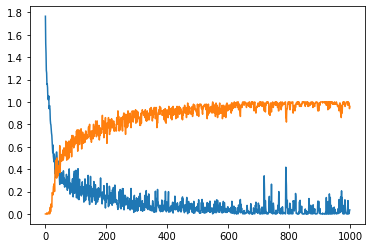

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:17<00:00, 219.21it/s]


1m 9s (- 21m 52s) (5000 5%) loss: 0.7090 acc: 0.1646
2m 17s (- 20m 38s) (10000 10%) loss: 0.2892 acc: 0.5558
3m 26s (- 19m 29s) (15000 15%) loss: 0.1884 acc: 0.7130
4m 34s (- 18m 19s) (20000 20%) loss: 0.1108 acc: 0.8448
5m 43s (- 17m 9s) (25000 25%) loss: 0.0721 acc: 0.9038
6m 52s (- 16m 2s) (30000 30%) loss: 0.0645 acc: 0.9232
8m 1s (- 14m 54s) (35000 35%) loss: 0.0640 acc: 0.9284
9m 10s (- 13m 45s) (40000 40%) loss: 0.0560 acc: 0.9416
10m 19s (- 12m 36s) (45000 45%) loss: 0.0450 acc: 0.9566
11m 28s (- 11m 28s) (50000 50%) loss: 0.0435 acc: 0.9546
12m 37s (- 10m 20s) (55000 55%) loss: 0.0288 acc: 0.9700
13m 46s (- 9m 10s) (60000 60%) loss: 0.0341 acc: 0.9682
14m 55s (- 8m 2s) (65000 65%) loss: 0.0240 acc: 0.9778
16m 5s (- 6m 53s) (70000 70%) loss: 0.0343 acc: 0.9712
17m 14s (- 5m 44s) (75000 75%) loss: 0.0225 acc: 0.9822
18m 22s (- 4m 35s) (80000 80%) loss: 0.0219 acc: 0.9810
19m 31s (- 3m 26s) (85000 85%) loss: 0.0278 acc: 0.9768
20m 40s (- 2m 17s) (90000 90%) loss: 0.0162 acc: 0.98

<Figure size 432x288 with 0 Axes>

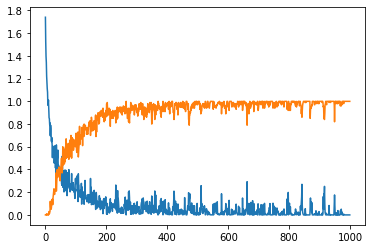

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:21<00:00, 180.07it/s]


1m 10s (- 22m 12s) (5000 5%) loss: 0.8543 acc: 0.0958
2m 18s (- 20m 45s) (10000 10%) loss: 0.2920 acc: 0.5648
3m 26s (- 19m 31s) (15000 15%) loss: 0.1952 acc: 0.7066
4m 35s (- 18m 22s) (20000 20%) loss: 0.1361 acc: 0.8016
5m 44s (- 17m 12s) (25000 25%) loss: 0.0968 acc: 0.8402
6m 53s (- 16m 3s) (30000 30%) loss: 0.0816 acc: 0.8612
8m 1s (- 14m 55s) (35000 35%) loss: 0.0649 acc: 0.8796
9m 11s (- 13m 46s) (40000 40%) loss: 0.0644 acc: 0.8888
10m 19s (- 12m 37s) (45000 45%) loss: 0.0650 acc: 0.8994
11m 28s (- 11m 28s) (50000 50%) loss: 0.0490 acc: 0.9198
12m 38s (- 10m 20s) (55000 55%) loss: 0.0532 acc: 0.9356
13m 47s (- 9m 11s) (60000 60%) loss: 0.0438 acc: 0.9560
14m 56s (- 8m 2s) (65000 65%) loss: 0.0325 acc: 0.9684
16m 5s (- 6m 53s) (70000 70%) loss: 0.0282 acc: 0.9728
17m 14s (- 5m 44s) (75000 75%) loss: 0.0224 acc: 0.9784
18m 23s (- 4m 35s) (80000 80%) loss: 0.0252 acc: 0.9772
19m 32s (- 3m 26s) (85000 85%) loss: 0.0241 acc: 0.9802
20m 41s (- 2m 17s) (90000 90%) loss: 0.0210 acc: 0.

<Figure size 432x288 with 0 Axes>

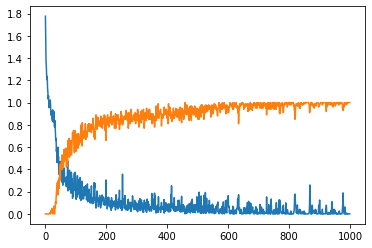

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:20<00:00, 191.81it/s]


1m 10s (- 22m 16s) (5000 5%) loss: 0.6478 acc: 0.2420
2m 18s (- 20m 45s) (10000 10%) loss: 0.2702 acc: 0.6190
3m 27s (- 19m 33s) (15000 15%) loss: 0.2057 acc: 0.6802
4m 35s (- 18m 20s) (20000 20%) loss: 0.1423 acc: 0.7632
5m 43s (- 17m 11s) (25000 25%) loss: 0.1069 acc: 0.8250
6m 53s (- 16m 3s) (30000 30%) loss: 0.0877 acc: 0.8518
8m 1s (- 14m 55s) (35000 35%) loss: 0.0726 acc: 0.8642
9m 10s (- 13m 45s) (40000 40%) loss: 0.0623 acc: 0.8800
10m 19s (- 12m 37s) (45000 45%) loss: 0.0623 acc: 0.8956
11m 28s (- 11m 28s) (50000 50%) loss: 0.0528 acc: 0.9018
12m 37s (- 10m 20s) (55000 55%) loss: 0.0573 acc: 0.9166
13m 46s (- 9m 11s) (60000 60%) loss: 0.0519 acc: 0.9210
14m 55s (- 8m 2s) (65000 65%) loss: 0.0447 acc: 0.9326
16m 4s (- 6m 53s) (70000 70%) loss: 0.0382 acc: 0.9532
17m 13s (- 5m 44s) (75000 75%) loss: 0.0502 acc: 0.9480
18m 22s (- 4m 35s) (80000 80%) loss: 0.0288 acc: 0.9642
19m 31s (- 3m 26s) (85000 85%) loss: 0.0294 acc: 0.9654
20m 40s (- 2m 17s) (90000 90%) loss: 0.0345 acc: 0.

<Figure size 432x288 with 0 Axes>

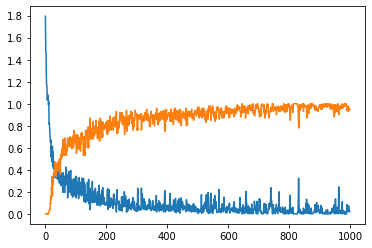

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:20<00:00, 193.52it/s]


1m 8s (- 21m 47s) (5000 5%) loss: 0.6768 acc: 0.2306
2m 17s (- 20m 35s) (10000 10%) loss: 0.2657 acc: 0.6108
3m 25s (- 19m 26s) (15000 15%) loss: 0.1592 acc: 0.7744
4m 34s (- 18m 18s) (20000 20%) loss: 0.0957 acc: 0.8796
5m 43s (- 17m 10s) (25000 25%) loss: 0.0678 acc: 0.9154
6m 52s (- 16m 1s) (30000 30%) loss: 0.0777 acc: 0.9242
8m 0s (- 14m 53s) (35000 35%) loss: 0.0540 acc: 0.9354
9m 9s (- 13m 44s) (40000 40%) loss: 0.0470 acc: 0.9490
10m 18s (- 12m 35s) (45000 45%) loss: 0.0422 acc: 0.9544
11m 27s (- 11m 27s) (50000 50%) loss: 0.0343 acc: 0.9646
12m 36s (- 10m 18s) (55000 55%) loss: 0.0406 acc: 0.9684
13m 46s (- 9m 10s) (60000 60%) loss: 0.0357 acc: 0.9674
14m 55s (- 8m 2s) (65000 65%) loss: 0.0267 acc: 0.9732
16m 4s (- 6m 53s) (70000 70%) loss: 0.0334 acc: 0.9742
17m 13s (- 5m 44s) (75000 75%) loss: 0.0403 acc: 0.9744
18m 22s (- 4m 35s) (80000 80%) loss: 0.0171 acc: 0.9840
19m 31s (- 3m 26s) (85000 85%) loss: 0.0408 acc: 0.9666
20m 40s (- 2m 17s) (90000 90%) loss: 0.0290 acc: 0.97

<Figure size 432x288 with 0 Axes>

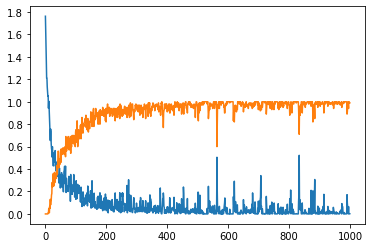

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:21<00:00, 184.36it/s]


In [ ]:
# top-performing model: GRU with Attention
main_run(hidden_size=50, num_iter=100000, num_runs=5, model='gru')

0m 24s (- 27m 55s) (1000 1%) loss: 1.1821 acc: 0.0100
0m 49s (- 28m 10s) (2000 2%) loss: 0.7220 acc: 0.0670
1m 13s (- 27m 14s) (3000 4%) loss: 0.4909 acc: 0.1750
1m 36s (- 26m 30s) (4000 5%) loss: 0.4066 acc: 0.2980
1m 59s (- 25m 55s) (5000 7%) loss: 0.3058 acc: 0.4290
2m 23s (- 25m 26s) (6000 8%) loss: 0.3092 acc: 0.5000
2m 46s (- 24m 57s) (7000 10%) loss: 0.2358 acc: 0.5650
3m 9s (- 24m 30s) (8000 11%) loss: 0.2011 acc: 0.6160
3m 33s (- 24m 5s) (9000 12%) loss: 0.1612 acc: 0.6780
3m 56s (- 23m 41s) (10000 14%) loss: 0.1382 acc: 0.7440
4m 20s (- 23m 16s) (11000 15%) loss: 0.1239 acc: 0.7770
4m 43s (- 22m 51s) (12000 17%) loss: 0.1126 acc: 0.7830
5m 7s (- 22m 28s) (13000 18%) loss: 0.0932 acc: 0.7790
5m 31s (- 22m 4s) (14000 20%) loss: 0.0690 acc: 0.8270
5m 54s (- 21m 40s) (15000 21%) loss: 0.0489 acc: 0.8630
6m 18s (- 21m 18s) (16000 22%) loss: 0.0885 acc: 0.8280
6m 42s (- 20m 54s) (17000 24%) loss: 0.0749 acc: 0.8370
7m 6s (- 20m 32s) (18000 25%) loss: 0.0742 acc: 0.8390
7m 30s (- 20

<Figure size 432x288 with 0 Axes>

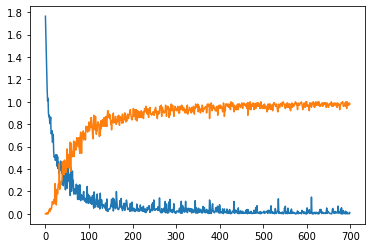

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:28<00:00, 135.76it/s]


0m 24s (- 28m 16s) (1000 1%) loss: 1.1596 acc: 0.0090
0m 47s (- 27m 3s) (2000 2%) loss: 0.6567 acc: 0.0780
1m 11s (- 26m 33s) (3000 4%) loss: 0.4581 acc: 0.2090
1m 34s (- 26m 5s) (4000 5%) loss: 0.3602 acc: 0.3660
1m 58s (- 25m 35s) (5000 7%) loss: 0.2888 acc: 0.4520
2m 21s (- 25m 7s) (6000 8%) loss: 0.2408 acc: 0.5500
2m 44s (- 24m 44s) (7000 10%) loss: 0.2049 acc: 0.5970
3m 8s (- 24m 18s) (8000 11%) loss: 0.1748 acc: 0.6750
3m 33s (- 24m 6s) (9000 12%) loss: 0.1640 acc: 0.6810
3m 58s (- 23m 49s) (10000 14%) loss: 0.1555 acc: 0.7080
4m 21s (- 23m 23s) (11000 15%) loss: 0.1273 acc: 0.7570
4m 45s (- 23m 0s) (12000 17%) loss: 0.0966 acc: 0.7790
5m 9s (- 22m 36s) (13000 18%) loss: 0.0893 acc: 0.7980
5m 32s (- 22m 11s) (14000 20%) loss: 0.0777 acc: 0.8400
5m 57s (- 21m 49s) (15000 21%) loss: 0.0612 acc: 0.8450
6m 21s (- 21m 26s) (16000 22%) loss: 0.0457 acc: 0.8820
6m 45s (- 21m 3s) (17000 24%) loss: 0.0591 acc: 0.8640
7m 8s (- 20m 38s) (18000 25%) loss: 0.0380 acc: 0.8950
7m 32s (- 20m 14

<Figure size 432x288 with 0 Axes>

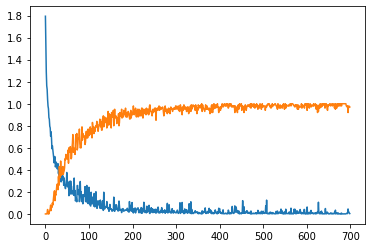

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:29<00:00, 135.07it/s]


0m 25s (- 29m 1s) (1000 1%) loss: 1.1648 acc: 0.0160
0m 49s (- 27m 58s) (2000 2%) loss: 0.6632 acc: 0.0970
1m 13s (- 27m 25s) (3000 4%) loss: 0.4717 acc: 0.2420
1m 38s (- 26m 57s) (4000 5%) loss: 0.3626 acc: 0.3530
2m 2s (- 26m 35s) (5000 7%) loss: 0.2989 acc: 0.4500
2m 27s (- 26m 12s) (6000 8%) loss: 0.2169 acc: 0.5790
2m 51s (- 25m 47s) (7000 10%) loss: 0.2108 acc: 0.6170
3m 16s (- 25m 22s) (8000 11%) loss: 0.1508 acc: 0.7080
3m 41s (- 24m 58s) (9000 12%) loss: 0.1399 acc: 0.7380
4m 5s (- 24m 34s) (10000 14%) loss: 0.1150 acc: 0.7520
4m 30s (- 24m 8s) (11000 15%) loss: 0.1016 acc: 0.8050
4m 54s (- 23m 44s) (12000 17%) loss: 0.0857 acc: 0.8630
5m 19s (- 23m 21s) (13000 18%) loss: 0.0650 acc: 0.8460
5m 44s (- 22m 57s) (14000 20%) loss: 0.0616 acc: 0.8890
6m 9s (- 22m 33s) (15000 21%) loss: 0.0578 acc: 0.8970
6m 34s (- 22m 9s) (16000 22%) loss: 0.0390 acc: 0.9000
6m 58s (- 21m 44s) (17000 24%) loss: 0.0549 acc: 0.9030
7m 23s (- 21m 20s) (18000 25%) loss: 0.0415 acc: 0.9150
7m 48s (- 20m

<Figure size 432x288 with 0 Axes>

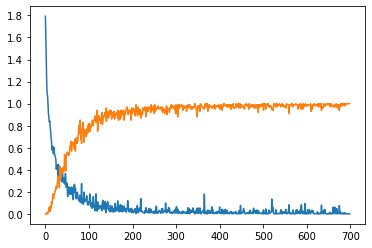

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:29<00:00, 132.78it/s]


0m 25s (- 29m 14s) (1000 1%) loss: 1.1560 acc: 0.0050
0m 49s (- 28m 13s) (2000 2%) loss: 0.7049 acc: 0.0860
1m 13s (- 27m 29s) (3000 4%) loss: 0.4779 acc: 0.2070
1m 38s (- 27m 5s) (4000 5%) loss: 0.3661 acc: 0.3470
2m 3s (- 26m 44s) (5000 7%) loss: 0.3078 acc: 0.4320
2m 28s (- 26m 22s) (6000 8%) loss: 0.2379 acc: 0.5430
2m 53s (- 25m 58s) (7000 10%) loss: 0.1676 acc: 0.6760
3m 17s (- 25m 32s) (8000 11%) loss: 0.1516 acc: 0.7070
3m 42s (- 25m 4s) (9000 12%) loss: 0.0982 acc: 0.7670
4m 6s (- 24m 40s) (10000 14%) loss: 0.0995 acc: 0.8130
4m 31s (- 24m 16s) (11000 15%) loss: 0.0777 acc: 0.8260
4m 55s (- 23m 50s) (12000 17%) loss: 0.0673 acc: 0.8710
5m 20s (- 23m 26s) (13000 18%) loss: 0.0668 acc: 0.8680
5m 45s (- 23m 2s) (14000 20%) loss: 0.0596 acc: 0.8920
6m 10s (- 22m 37s) (15000 21%) loss: 0.0496 acc: 0.8850
6m 35s (- 22m 13s) (16000 22%) loss: 0.0439 acc: 0.9000
7m 0s (- 21m 52s) (17000 24%) loss: 0.0411 acc: 0.9030
7m 26s (- 21m 30s) (18000 25%) loss: 0.0422 acc: 0.9060
7m 51s (- 21m

<Figure size 432x288 with 0 Axes>

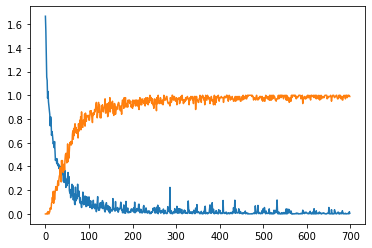

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:30<00:00, 130.02it/s]


0m 25s (- 29m 8s) (1000 1%) loss: 1.1654 acc: 0.0090
0m 49s (- 28m 15s) (2000 2%) loss: 0.6916 acc: 0.0640
1m 14s (- 27m 41s) (3000 4%) loss: 0.4818 acc: 0.2100
1m 39s (- 27m 16s) (4000 5%) loss: 0.3968 acc: 0.2940
2m 3s (- 26m 47s) (5000 7%) loss: 0.3288 acc: 0.4200
2m 27s (- 26m 18s) (6000 8%) loss: 0.2277 acc: 0.5640
2m 52s (- 25m 50s) (7000 10%) loss: 0.2107 acc: 0.6170
3m 16s (- 25m 25s) (8000 11%) loss: 0.1736 acc: 0.6800
3m 41s (- 25m 3s) (9000 12%) loss: 0.1354 acc: 0.7200
4m 6s (- 24m 37s) (10000 14%) loss: 0.1178 acc: 0.7810
4m 30s (- 24m 13s) (11000 15%) loss: 0.0871 acc: 0.7860
4m 56s (- 23m 54s) (12000 17%) loss: 0.0960 acc: 0.8170
5m 21s (- 23m 31s) (13000 18%) loss: 0.0688 acc: 0.8500
5m 46s (- 23m 6s) (14000 20%) loss: 0.0555 acc: 0.8780
6m 11s (- 22m 43s) (15000 21%) loss: 0.0464 acc: 0.9180
6m 36s (- 22m 18s) (16000 22%) loss: 0.0515 acc: 0.8950
7m 1s (- 21m 53s) (17000 24%) loss: 0.0534 acc: 0.9090
7m 26s (- 21m 29s) (18000 25%) loss: 0.0531 acc: 0.9080
7m 51s (- 21m

<Figure size 432x288 with 0 Axes>

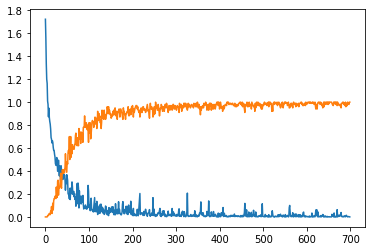

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:29<00:00, 134.98it/s]


In [ ]:
# overall best model: LSTM
main_run(hidden_size=200, num_iter=100000, num_runs=5, model='lstm')

In [ ]:
# Load saved models and results
with open('models_gru.pickle', 'rb') as f:
    [best_encoder_gru, best_decoder_gru, best_acc_gru] = pickle.load(f)
with open('models_lstm.pickle', 'rb') as f:
    [best_encoder_lstm, best_decoder_lstm, best_acc_lstm] = pickle.load(f)
with open('train_results_gru.pickle', 'rb') as f:
    [command_accs_gru, action_accs_gru, overall_accs_gru, train_accs_gru] = pickle.load(f)
with open('train_results_lstm.pickle', 'rb') as f:
    [command_accs_lstm, action_accs_lstm, overall_accs_lstm, train_accs_lstm] = pickle.load(f)

best_encoder_lstm.to(device)
best_decoder_lstm.to(device)
best_encoder_gru.to(device)
best_decoder_gru.to(device)

AttnDecoderGRU(
  (embedding): Embedding(8, 50)
  (tanh): Tanh()
  (Ua): Linear(in_features=50, out_features=50, bias=True)
  (Wa): Linear(in_features=50, out_features=50, bias=True)
  (attn_combine): Linear(in_features=100, out_features=50, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(50, 50)
  (out): Linear(in_features=100, out_features=8, bias=True)
)

In [ ]:
command_mean_gru, command_error_gru, command_keys = calculate_mean_std(command_accs_gru)
action_mean_gru, action_error_gru, action_keys = calculate_mean_std(action_accs_gru)

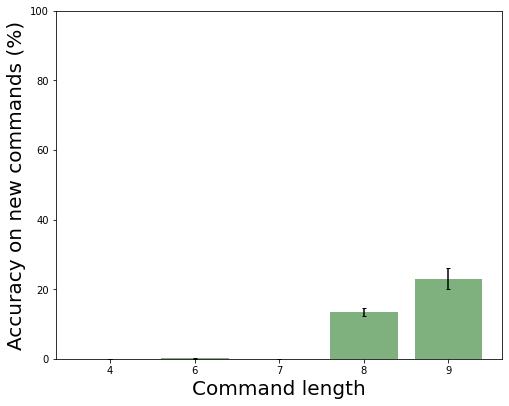

In [ ]:
# Plot the results for commands
plt.rcParams['figure.figsize'] = (8,6.4)
fig, ax = plt.subplots()
ax.bar(np.arange(len(command_mean_gru)), command_mean_gru, yerr=command_error_gru, 
       align='center', alpha=0.5, ecolor='black', color = 'darkgreen', capsize=2)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, symbol=None))
ax.set_ylabel('Accuracy on new commands (%)', fontsize=20)
ax.set_xlabel('Command length', fontsize=20)
ax.set_xticks(np.arange(len(command_keys)))
ax.set_xticklabels(command_keys)
ax.set_yticks(np.arange(0,1.1, 0.2))

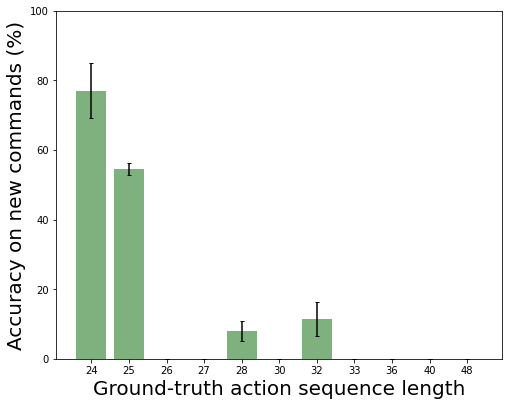

In [ ]:
# Plot the results for actions
plt.rcParams['figure.figsize'] = (8,6.4)
fig, ax = plt.subplots()
ax.bar(np.arange(len(action_mean_gru)), action_mean_gru, yerr=action_error_gru, 
       align='center', alpha=0.5, ecolor='black', color = 'darkgreen', capsize=2)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, symbol=None))
ax.set_ylabel('Accuracy on new commands (%)', fontsize=20)
ax.set_xlabel('Ground-truth action sequence length', fontsize=20)
ax.set_xticks(np.arange(len(action_keys)))
ax.set_xticklabels(action_keys)
ax.set_yticks(np.arange(0,1.1, 0.2))

input = ['jump', 'around', 'right', 'and', 'walk', 'around', 'left', 'twice']
output = ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', '<EOS>']


C:\Users\刘兆祺\AppData\Local\Temp\ipykernel_21124\1152974012.py:349: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['<SOS>'] + input_sentence, fontsize=15)
C:\Users\刘兆祺\AppData\Local\Temp\ipykernel_21124\1152974012.py:350: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + output_words, rotation=90, fontsize=15)


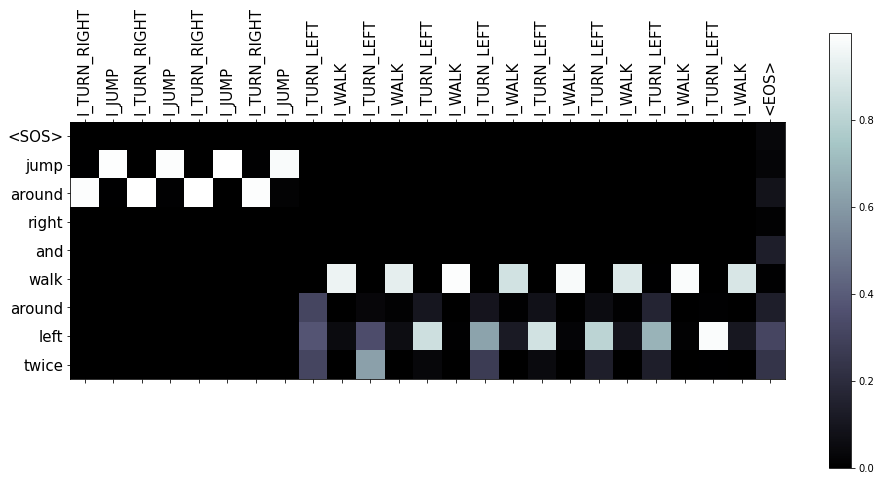

In [ ]:
# Visualize attention of correct example
evaluateAndShowAttentionExample(best_encoder_gru, best_decoder_gru, model='gru')

In [ ]:
# Print overall accuracy
overall_acc_lstm = np.mean(overall_accs_lstm)
print("Test accuracy of LSTM:", overall_acc_lstm)
train_acc_lstm = np.mean(train_accs_lstm)
print("Train accuracy of LSTM:", train_acc_lstm)
overall_acc_gru = np.mean(overall_accs_gru)
print("Test accuracy of GRU:", overall_acc_gru)
train_acc_gru = np.mean(train_accs_gru)
print("Train accuracy of GRU:", train_acc_gru)

Test accuracy of LSTM: 0.13933673469387756
Train accuracy of LSTM: 0.9857999999999999
Test accuracy of GRU: 0.1507142857142857
Train accuracy of GRU: 0.9837999999999999


In [ ]:
# Evaluate models with predictions of fix length
acc_command_gru_fix, acc_action_gru_fix, acc_overall_gru_fix = evaluate_model_fix(
    best_encoder_gru, best_decoder_gru, pairs_test, model='gru')
print('Overall test accuracy of GRU with fixed length:', acc_overall_gru_fix)
acc_command_lstm_fix, acc_action_lstm_fix, acc_overall_lstm_fix = evaluate_model_fix(
    best_encoder_lstm, best_decoder_lstm, pairs_test, model='lstm')
print('Overall test accuracy of LSTM with fixed length:', acc_overall_lstm_fix)

100%|██████████████████████████████████████████████████████████████████████████████| 3920/3920 [01:28<00:00, 44.33it/s]


Overall test accuracy of GRU with fixed length: 0.5724489795918367


100%|██████████████████████████████████████████████████████████████████████████████| 3920/3920 [00:59<00:00, 65.62it/s]

Overall test accuracy of LSTM with fixed length: 0.2451530612244898


In [ ]:
def evaluate_search_failure(encoder, decoder, pair, model='gru', max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor, target_tensor = tensorsFromPair(pair, command_le, action_le)
        target_output = pair[1]
        input_length = input_tensor.size()[0]
        target_length = target_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_hiddens = torch.zeros(input_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            
            if model == 'gru':
                encoder_hiddens[ei] += encoder_hidden[0, 0]

        decoded_words_tf = []
        decoded_words_sg = []
        cumul_prob_tf = torch.tensor(0, dtype=torch.float).to(device)
        cumul_prob_sg = torch.tensor(0, dtype=torch.float).to(device)
        
        # Teacher forcing evaluation
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        
        for di in range(target_length):
            if model == 'gru':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_hiddens)
            elif model == 'lstm':
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            cumul_prob_tf += topv.squeeze().item()
            
            if topi.item() == EOS_token:
                break
            else:
                decoded_words_tf.append(action_le.index2word[topi.item()])
                
            decoder_input = target_tensor[di]
        
        # Self generated evaluation
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        
        for di in range(max_length):
            if model == 'gru':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_hiddens)
            elif model == 'lstm':
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            cumul_prob_sg += topv.squeeze().item()
            
            if topi.item() == EOS_token:
                break
            else:
                decoded_words_sg.append(action_le.index2word[topi.item()])
                
            decoder_input = topi.squeeze()
        
        both_wrong = (decoded_words_tf != target_output) and (decoded_words_sg != target_output)
        return both_wrong, cumul_prob_sg.item(), cumul_prob_tf.item()


def evaluate_model_search_failure(encoder, decoder, test_pairs, model='gru'):
    probs_sg = []
    probs_tf = []
    
    for pair in tqdm(test_pairs):
        both_wrong, sg_prob, tf_prob = evaluate_search_failure(encoder, decoder, pair, model=model)
        
        if both_wrong:
            probs_sg.append(sg_prob)
            probs_tf.append(tf_prob)
            
    return probs_sg, probs_tf

In [ ]:
probs_sg, probs_tf = evaluate_model_search_failure(best_encoder_gru, best_decoder_gru, pairs_test)

100%|██████████████████████████████████████████████████████████████████████████████| 3920/3920 [02:20<00:00, 27.82it/s]


In [ ]:
sum(probs_sg), sum(probs_tf)

(-126.33806966018165, -451.94924910590635)